In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
#from cnn_utils import *
import pandas as pd

%matplotlib inline
np.random.seed(1)

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
df=pd.read_csv('C:/Python36(64bit)/programs/intern/fer2013.csv')

NameError: name 'pd' is not defined

In [3]:
df1=df[:6500]
    
df2=df1.drop('Usage',axis=1)

train=df2[:6000]
test= df2[6000:6500]
train_x=train.drop('emotion',axis=1)
#train_y=train['emotion']
test_x=test.drop('emotion',axis=1)
train_y=train.drop('pixels',axis=1)
#test_y=test['emotion']
train_x= train_x['pixels'].str.split(' ',expand=True) 
train_x=train_x.astype('float')
test_x= test_x['pixels'].str.split(' ',expand=True) 
test_x=test_x.astype('float')


NameError: name 'df' is not defined

In [17]:
test_y=test.drop('pixels',axis=1)
Y_test1=test_y
train_x1=train_x
test_x1=test_x
Y_train1=train_y

X_train1=train_x1.values
X_test1=test_x1.values

X_train2=X_train1/255
X_test2=X_test1/255

Y_test2=Y_test1.values
Y_train2=Y_train1.values

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
Y_train3 = convert_to_one_hot(Y_train2, 7)
Y_test3 = convert_to_one_hot(Y_test2, 7)
Y_train=Y_train3.T
Y_test=Y_test3.T

##reshape
X_train=X_train2.reshape(X_train2.shape[0],48,48,1)
X_test=X_test2.reshape(X_test2.shape[0],48,48,1)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 6000
number of test examples = 500
X_train shape: (6000, 48, 48, 1)
Y_train shape: (6000, 7)
X_test shape: (500, 48, 48, 1)
Y_test shape: (500, 7)


In [18]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


In [23]:

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32, shape= [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape =[None, n_y])
    ### END CODE HERE ###
    
    return X, Y

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 1, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1", shape=[4, 4, 1, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", shape=[2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
     # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    print(A1.shape)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding='SAME')
    print(P1.shape)
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    print(A2.shape)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding='SAME')
    # FLATTEN
    print(P2.shape)
    P = tf.contrib.layers.flatten(P2)
    print(P.shape)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 7 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P, 7, activation_fn=None)
    print(Z3.shape)
    ### END CODE HERE ###


    return Z3

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost =   cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    ### END CODE HERE ###
    
    return cost

In [20]:

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
        
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                ### END CODE HERE ###
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        fig = plt.figure()
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        fig.savefig("graph.png")
     


        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.839861
Cost after epoch 10: 1.626417
Cost after epoch 20: 1.530100
Cost after epoch 30: 1.499774
Cost after epoch 40: 1.466964
Cost after epoch 50: 1.455192
Cost after epoch 60: 1.447458
Cost after epoch 70: 1.445986
Cost after epoch 80: 1.445656
Cost after epoch 90: 1.440252


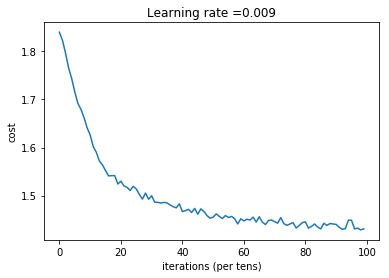

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.4595
Test Accuracy: 0.42


In [21]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [47]:
fname = "C:/Python36(64bit)/programs/intern/karan.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(48,48))
#plt.imshow(my_image)

In [35]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    #b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    #b2 = tf.convert_to_tensor(parameters["b2"])
    #W3 = tf.convert_to_tensor(parameters["W3"])
    #b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              #"b1": b1,
              "W2": W2}
              #"b2": b2,
              #"W3": W3,
              #"b3": b3}
    
    x = tf.placeholder("float", [1,48,48,1])
    
    z3 = forward_propagation_for_predict(x, parameters)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction


In [22]:
#my_image_prediction = predict(my_image, parameters)
#print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))